In [1]:
import sys
sys.path.append("../")
from helper import set_datetime_index, exp_time_data
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime, DataFrame
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [2]:
# 데이터 불러오기
origin = read_excel("../Excel Data/세종시_친환경차_보급율_현황(2013_2023).xlsx")
origin.head()

,년도,전기차(대수),전기차_전년대비_증가율,하이브리드(대수),하이브리드_전년대비_증가율,수소(대수),수소차_전년대비_증가율,친환경차총합(대수),친환경차총합_전년대비_증가율,친환경차외(대수),세종시차량총합(대수),친환경차비율(%)
0,201303,0,0.0,235,0.00,0,0.0,235,0.00,49328,49563,0.5
1,201306,0,0.0,282,0.20,0,0.0,282,0.20,50394,50676,0.5
2,201309,0,0.0,310,0.10,0,0.0,310,0.10,51188,51498,0.6
3,201312,4,4.0,346,0.11,0,0.0,350,0.13,52539,52889,0.6
4,201403,4,0.0,413,0.19,0,0.0,417,0.19,54975,55392,0.7


In [3]:
# 기존 데이터 프레임 copy
df=origin.copy()
df.head()

,년도,전기차(대수),전기차_전년대비_증가율,하이브리드(대수),하이브리드_전년대비_증가율,수소(대수),수소차_전년대비_증가율,친환경차총합(대수),친환경차총합_전년대비_증가율,친환경차외(대수),세종시차량총합(대수),친환경차비율(%)
0,201303,0,0.0,235,0.00,0,0.0,235,0.00,49328,49563,0.5
1,201306,0,0.0,282,0.20,0,0.0,282,0.20,50394,50676,0.5
2,201309,0,0.0,310,0.10,0,0.0,310,0.10,51188,51498,0.6
3,201312,4,4.0,346,0.11,0,0.0,350,0.13,52539,52889,0.6
4,201403,4,0.0,413,0.19,0,0.0,417,0.19,54975,55392,0.7


In [4]:
# 시계열 분석에 사용할 변수만 추출
df2=df.filter(['년도','전기차(대수)','하이브리드(대수)','수소(대수)','친환경차총합(대수)'])

In [5]:
# 데이터 타입 확인
df2.dtypes

년도            int64
전기차(대수)       int64
하이브리드(대수)     int64
수소(대수)        int64
친환경차총합(대수)    int64
dtype: object

In [6]:
# `년도` 컬럼 시계열 분석에 맞게끔 타입 변경
df2['년도']=to_datetime(df2['년도'],format='%Y%m')
df2.dtypes

년도            datetime64[ns]
전기차(대수)                int64
하이브리드(대수)              int64
수소(대수)                 int64
친환경차총합(대수)             int64
dtype: object

In [7]:
# 결측치 확인
df2.isna().sum()

년도            0
전기차(대수)       0
하이브리드(대수)     0
수소(대수)        0
친환경차총합(대수)    0
dtype: int64

In [8]:
df2.head()

,년도,전기차(대수),하이브리드(대수),수소(대수),친환경차총합(대수)
0,2013-03-01,0,235,0,235
1,2013-06-01,0,282,0,282
2,2013-09-01,0,310,0,310
3,2013-12-01,4,346,0,350
4,2014-03-01,4,413,0,417


In [9]:
# `년도` 컬럼 인덱스로 설정
df2.set_index('년도',inplace=True)
df2.head()

,전기차(대수),하이브리드(대수),수소(대수),친환경차총합(대수)
년도,,,,
2013-03-01,0,235,0,235
2013-06-01,0,282,0,282
2013-09-01,0,310,0,310
2013-12-01,4,346,0,350
2014-03-01,4,413,0,417


### 전기차(대수) 시계열 분석

In [10]:
model_name = 'additive'         # 가법 모델
# model_name = 'multiplicative'   # 승법 모델

sd = seasonal_decompose(df2['전기차(대수)'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df = DataFrame({
    '관측값': sd.observed,
    '트렌드': sd.trend,
    '계절성': sd.seasonal,
    '잔차': sd.resid
}, index=df2.index)

sd_df.head()

,관측값,트렌드,계절성,잔차
년도,,,,
2013-03-01,0.0,NaN,-2.619097,NaN
2013-06-01,0.0,NaN,7.005903,NaN
2013-09-01,0.0,1.5,4.362847,-5.862847
2013-12-01,4.0,2.5,-8.749653,10.249653
2014-03-01,4.0,3.5,-2.619097,3.119097


결측치 수: 0


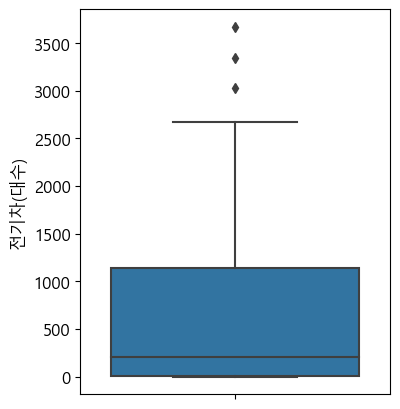

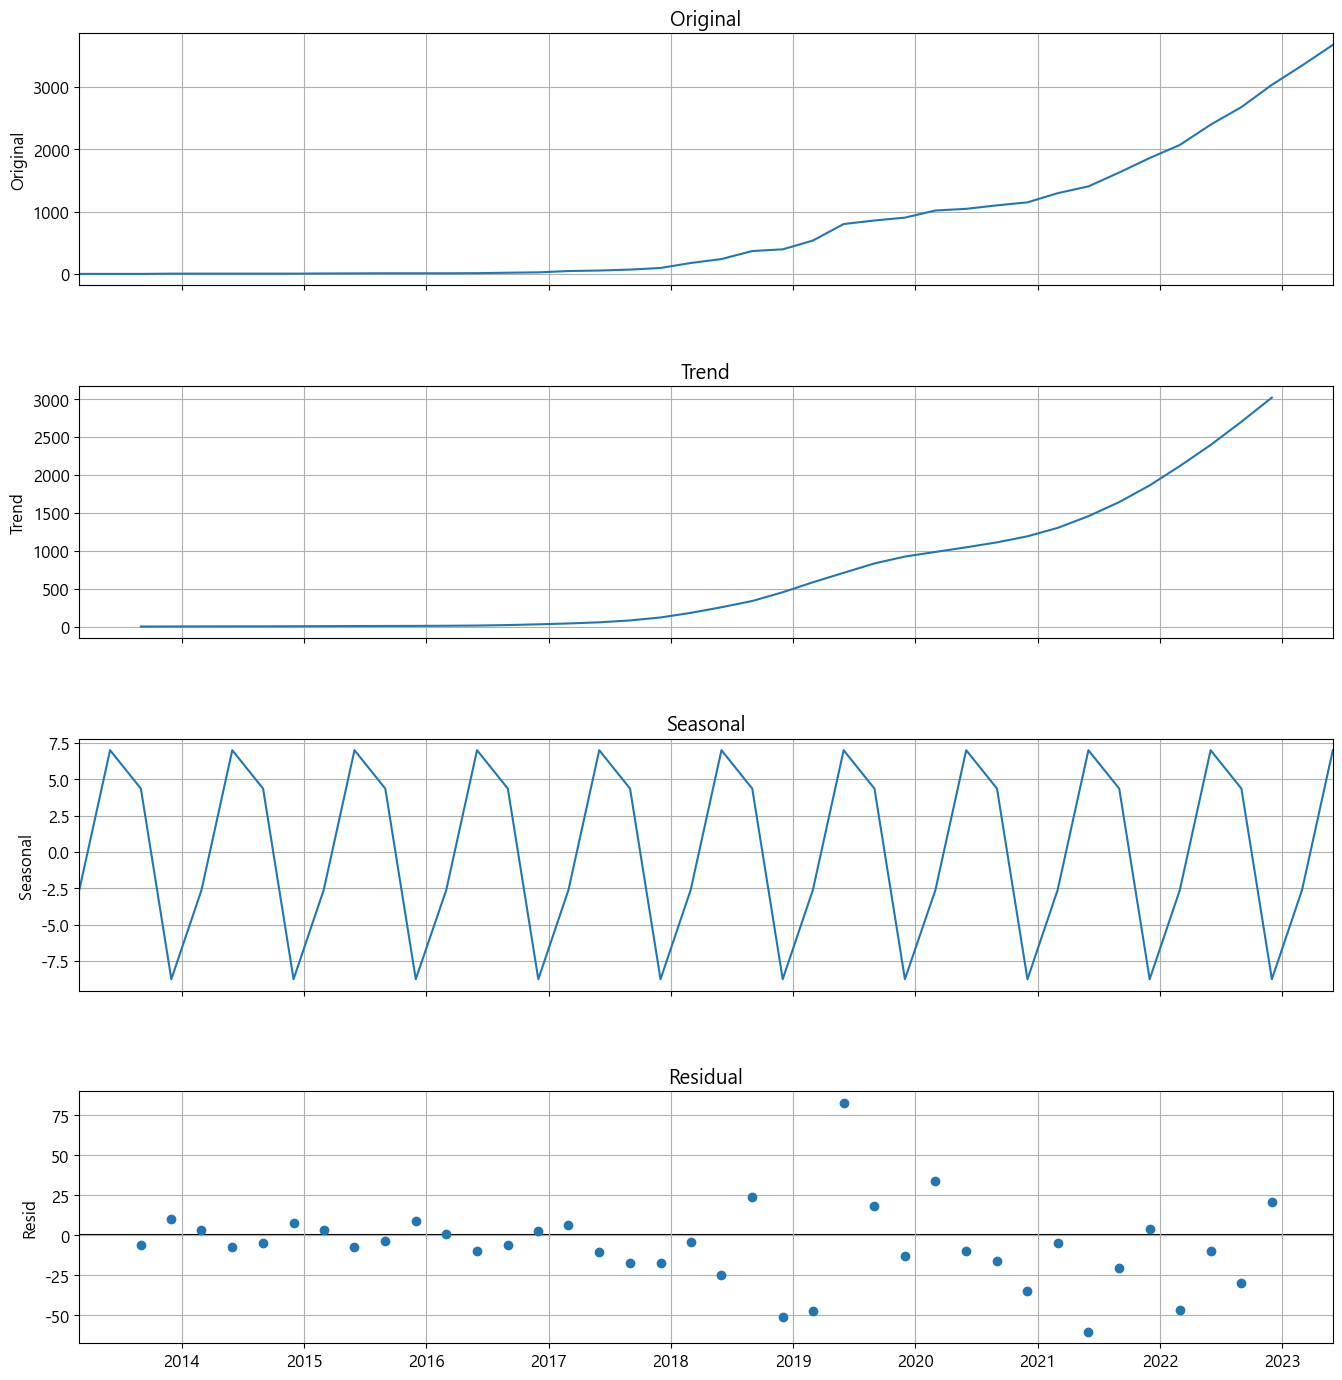

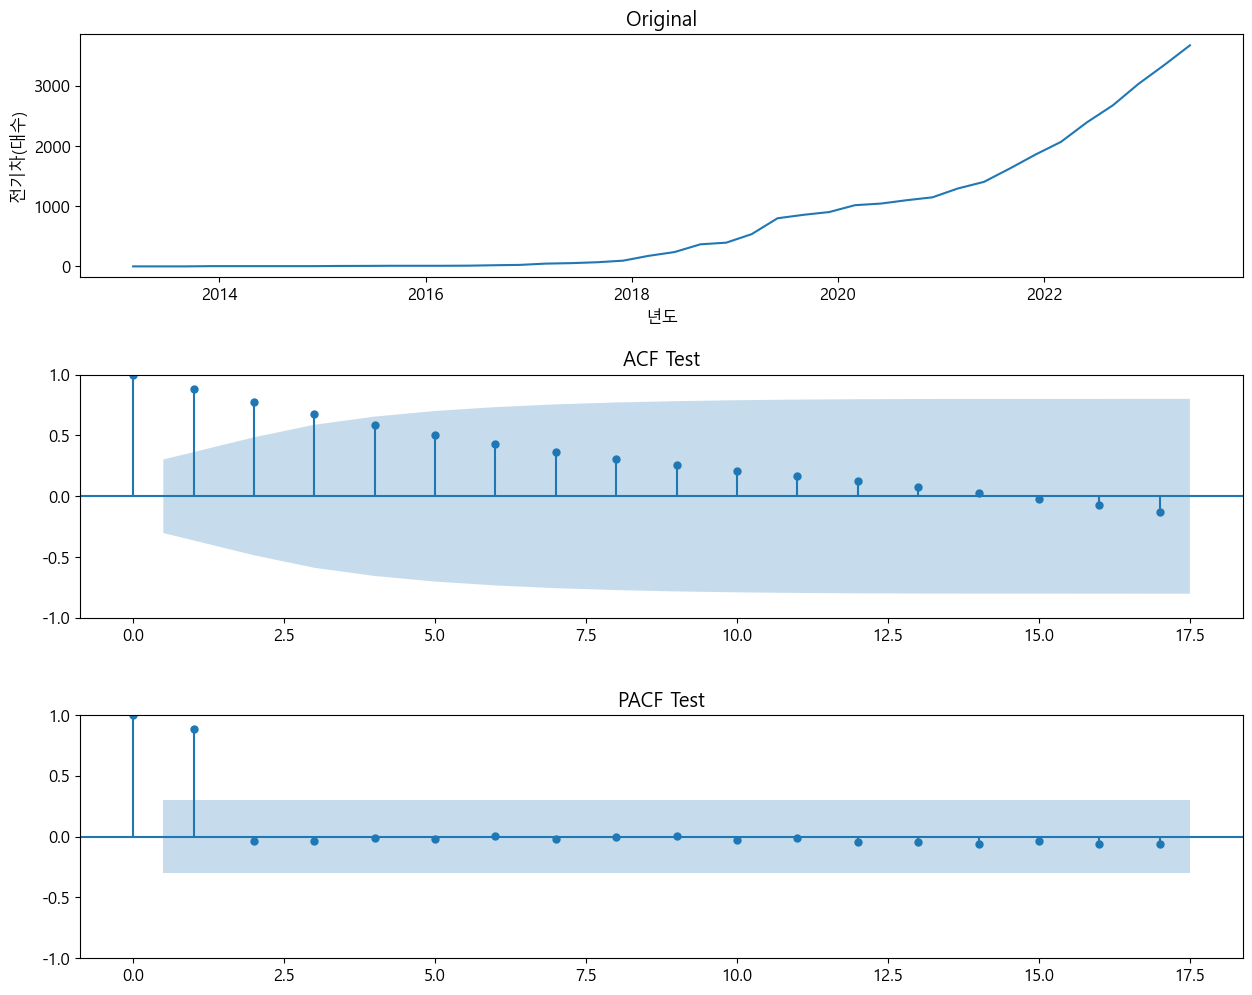

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          |  12.1114 |
| 유의수준(p-value)                  |        1 |
| 최적차수(num of lags)              |        0 |
| 관측치 개수(num of observations)   |       41 |
| 기각값(Critical Values) 1%         | -3.60098 |
| 기각값(Critical Values) 5%         | -2.93513 |
| 기각값(Critical Values) 10%        | -2.60596 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | 0.699939 |
| 유의수준(p-value)                  | 0.989837 |
| 최적차수(num of lags)              |        2 |
| 관측치 개수(num of observations)   |       38 |
| 기각값(Critical Values) 1%         | -3

In [11]:
exp_time_data(data=df2,yname="전기차(대수)",sd_model='a',max_diff=5)

In [12]:
#auto arima 모델 이용하여 시계열 분석 진행

my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 2    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 3    # 계절성 주기 (분석가가 판단) #1년에 4분기(12/4)로 진행해서 수치는 3으로,(데이터 자체도 3개월주기)

model = auto_arima(
    y=df2['전기차(대수)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[3]             : AIC=420.995, Time=0.01 sec
 ARIMA(1,2,0)(1,2,0)[3]             : AIC=414.505, Time=0.04 sec
 ARIMA(1,2,0)(0,2,0)[3]             : AIC=416.979, Time=0.00 sec
 ARIMA(0,2,0)(1,2,0)[3]             : AIC=419.126, Time=0.03 sec
 ARIMA(1,2,0)(1,2,0)[3] intercept   : AIC=416.487, Time=0.05 sec

Best model:  ARIMA(1,2,0)(1,2,0)[3]          
Total fit time: 0.135 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   42
Model:             SARIMAX(1, 2, 0)x(1, 2, 0, 3)   Log Likelihood                -204.253
Date:                           Mon, 18 Sep 2023   AIC                            414.505
Time:                                   01:36:23   BIC                            419.084
Sample:                               03-01-2013   HQIC                           416.067
               

In [13]:
fv = model.fittedvalues()
fv.head()

년도
2013-03-01    0.000000
2013-06-01    0.000000
2013-09-01    0.000000
2013-12-01    0.000000
2014-03-01    6.707396
dtype: float64

In [14]:
fc = model.predict(n_periods=8)
fc.head()

2023-09-01    4092.898449
2023-12-01    4380.897874
2024-03-01    4705.117078
2024-06-01    5163.861559
2024-09-01    5379.117466
Freq: QS-DEC, dtype: float64

In [15]:
last1 = df2.index.min()
last = df2.index.max()
xmin = last1
xmax = last+timedelta(days=730+100)
ymax = df2['전기차(대수)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2013-03-01 00:00:00'), Timestamp('2025-09-08 00:00:00'), 3674)

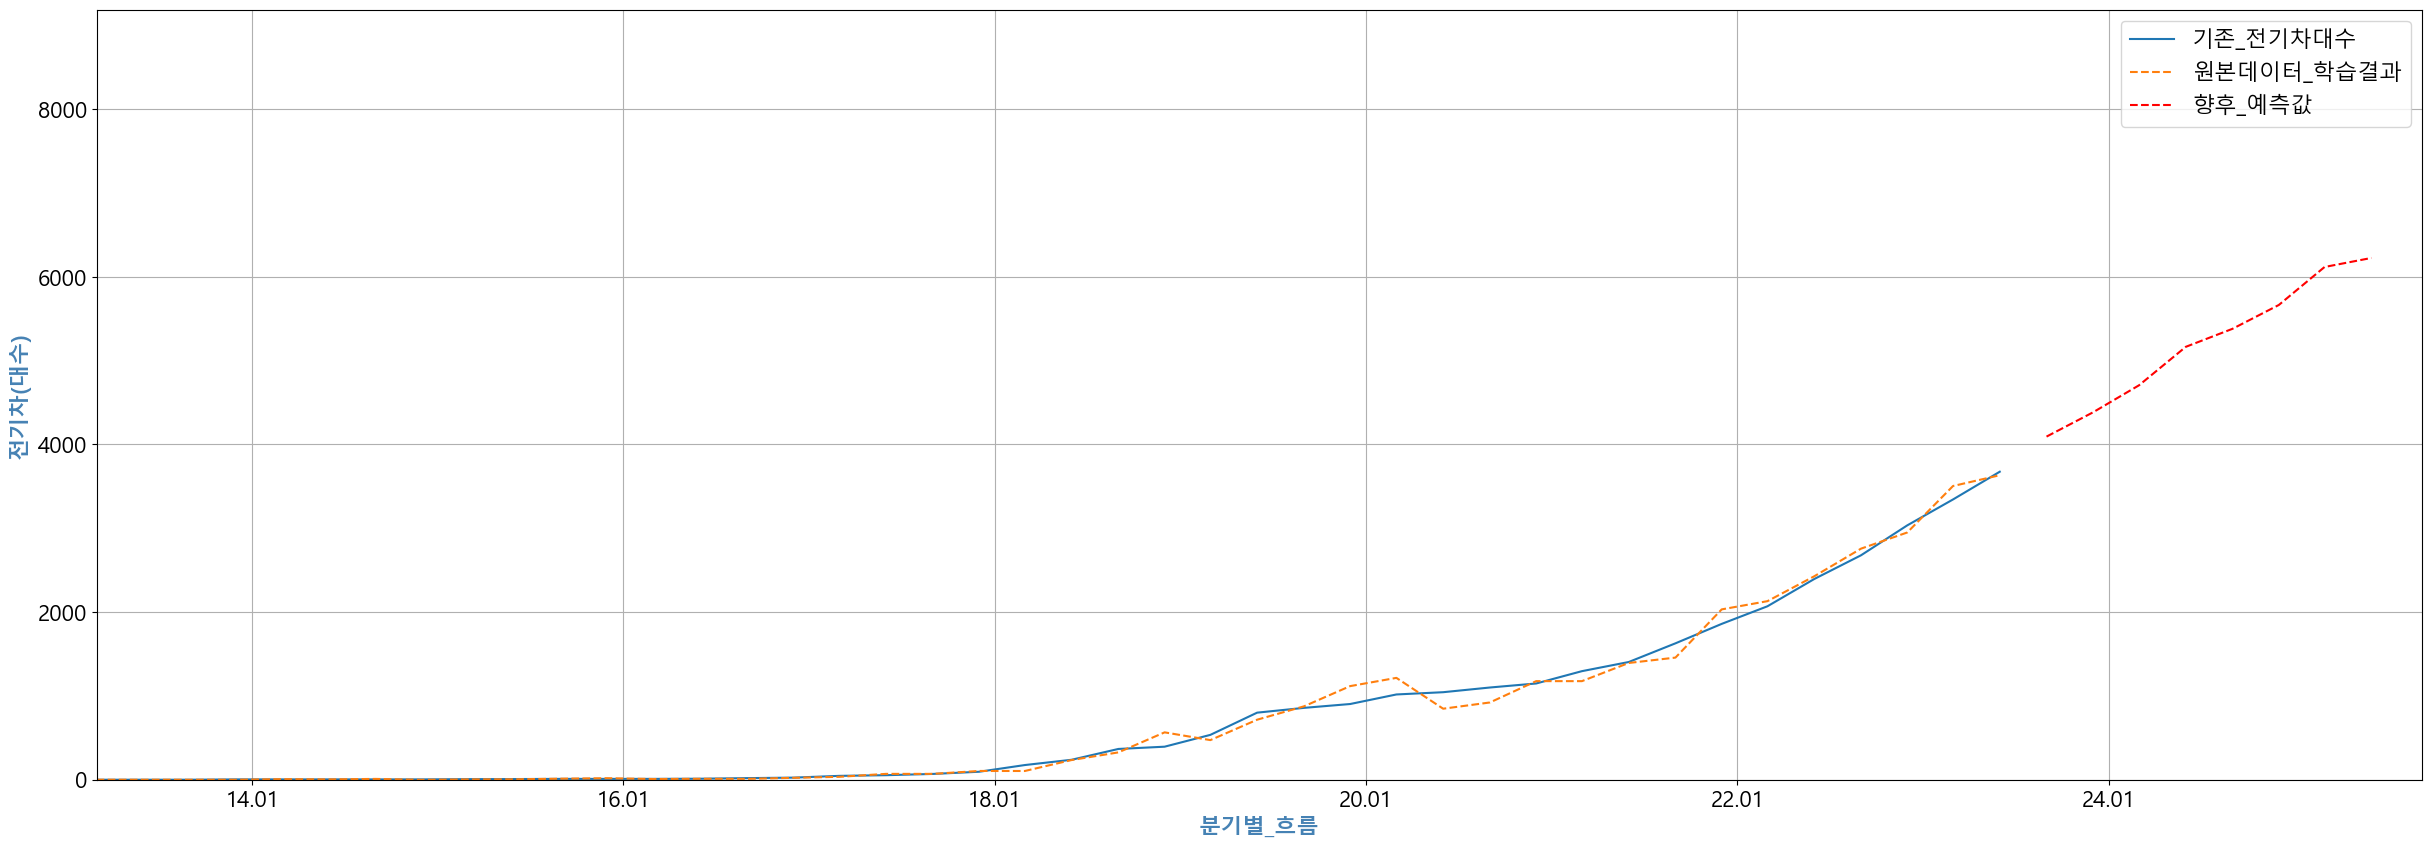

In [16]:
plt.rcParams["font.size"] = 16

plt.figure(figsize=(30,10))

# 원본 데이터
sb.lineplot(data=df2, x=df2.index, y='전기차(대수)', label='기존_전기차대수')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='원본데이터_학습결과', linestyle='--')

# 향후 2년간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='향후_예측값', linestyle='--', color='red')

plt.xlabel('분기별_흐름',color='steelblue',fontweight='bold')
plt.ylabel('전기차(대수)',color='steelblue',fontweight='bold')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*2.5])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

> 전기차의 경우 향후 2년간 지속적인 상승세가 예측되며 25년 3분기 기준(현재시점 기준 2년 후) 6000대를 넘을것으로 예상된다.

### 하이브리드(대수) 시계열 분석

In [17]:
model_name = 'additive'         # 가법 모델
# model_name = 'multiplicative'   # 승법 모델

sd2 = seasonal_decompose(df2['하이브리드(대수)'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df2 = DataFrame({
    '관측값': sd2.observed,
    '트렌드': sd2.trend,
    '계절성': sd2.seasonal,
    '잔차': sd2.resid
}, index=df2.index)

sd_df2.head()

,관측값,트렌드,계절성,잔차
년도,,,,
2013-03-01,235.0,NaN,5.880208,NaN
2013-06-01,282.0,NaN,14.255208,NaN
2013-09-01,310.0,315.500,-23.936458,18.436458
2013-12-01,346.0,362.375,3.801042,-20.176042
2014-03-01,413.0,411.750,5.880208,-4.630208


결측치 수: 0


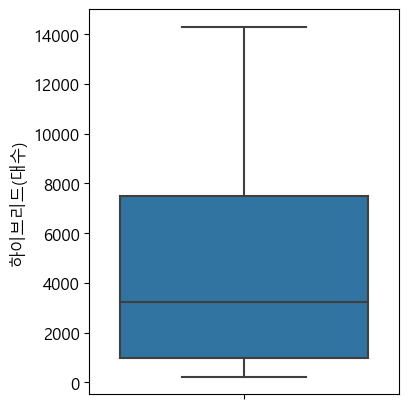

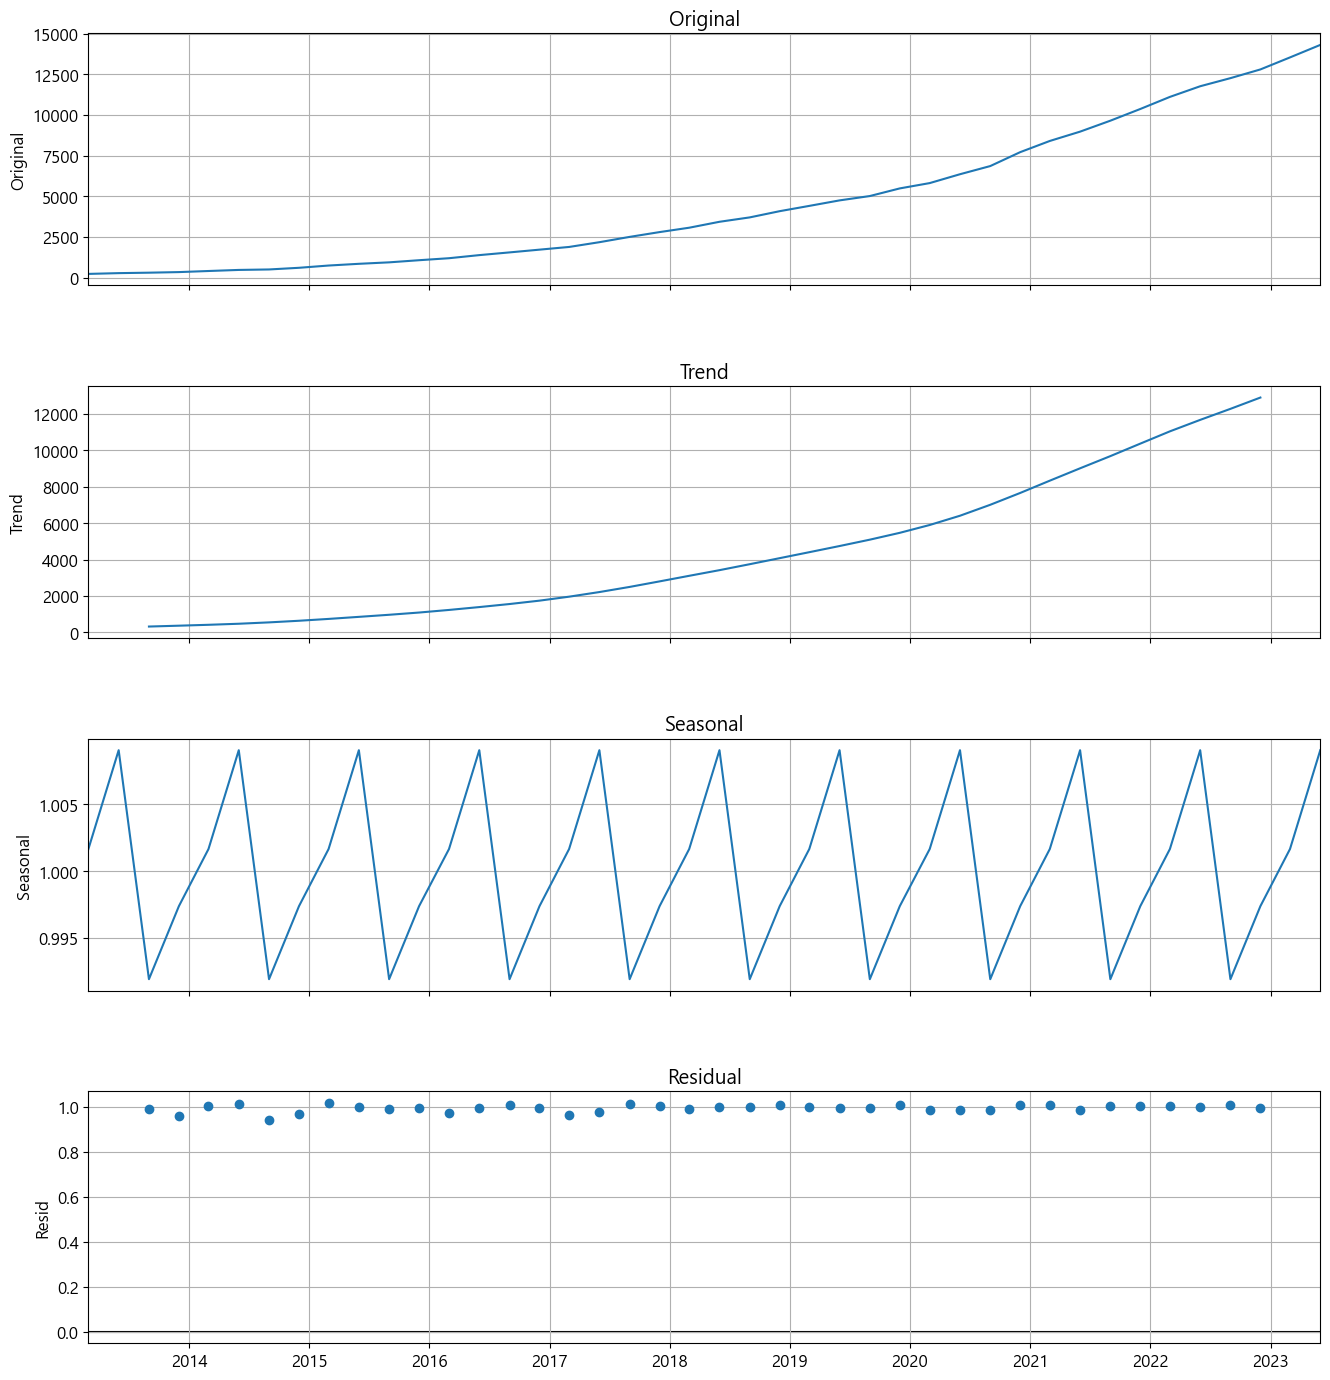

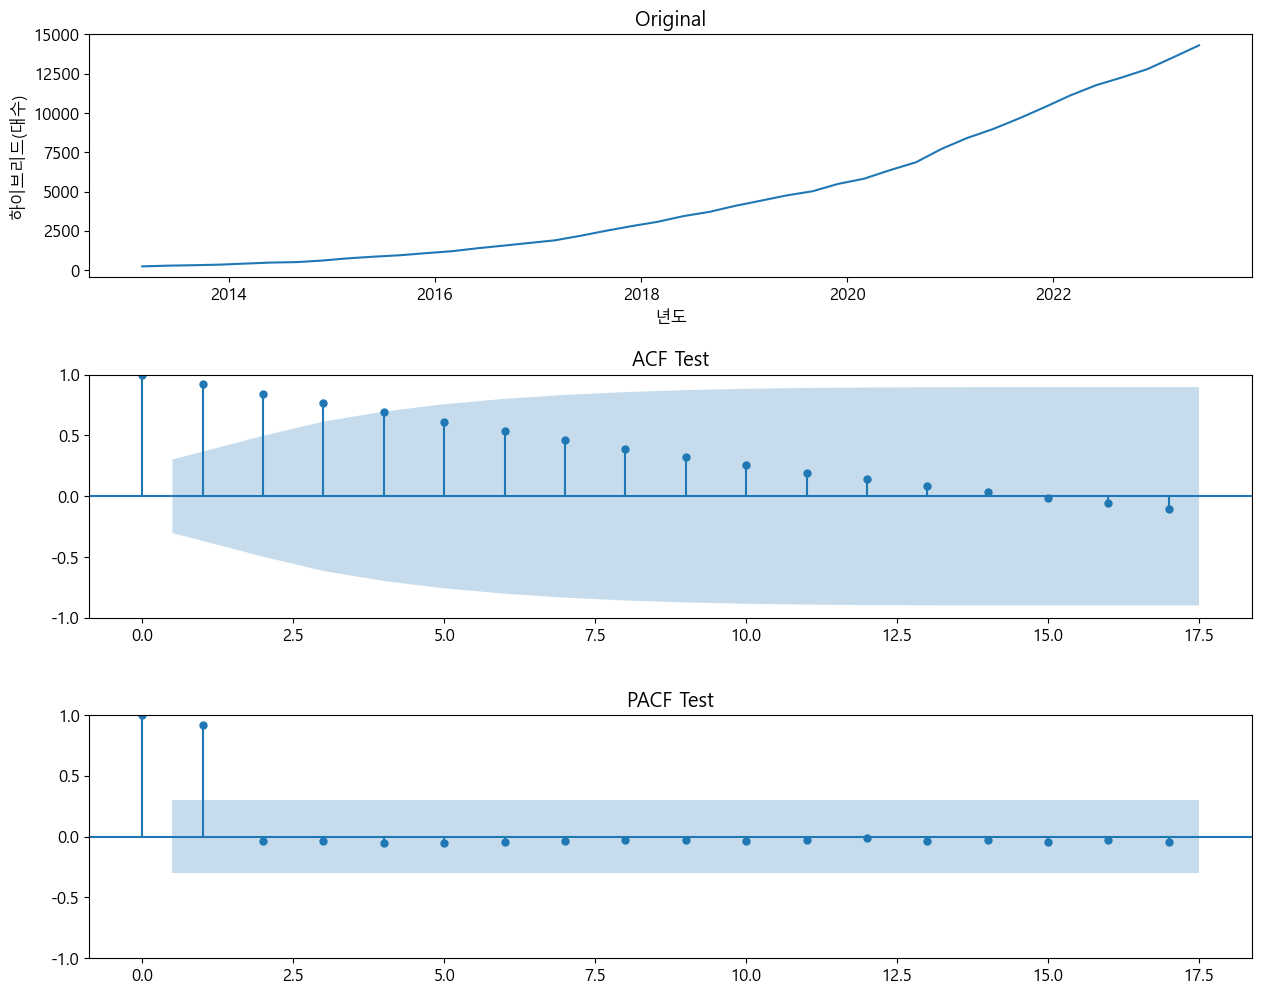

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          |  2.98809 |
| 유의수준(p-value)                  |        1 |
| 최적차수(num of lags)              |        1 |
| 관측치 개수(num of observations)   |       40 |
| 기각값(Critical Values) 1%         | -3.60556 |
| 기각값(Critical Values) 5%         | -2.93707 |
| 기각값(Critical Values) 10%        | -2.60699 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          | -0.346057 |
| 유의수준(p-value)                  |  0.918723 |
| 최적차수(num of lags)              |         3 |
| 관측치 개수(num of observations)   |        37 |
| 기각값(Critical Values) 1%      

In [18]:
exp_time_data(data=df2,yname="하이브리드(대수)",sd_model='m',max_diff=5)

In [19]:
#auto arima 모델 이용하여 시계열 분석 진행

my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 2    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 3    # 계절성 주기 (분석가가 판단) #1년에 4분기(12/4)로 진행해서 수치는 3으로,(데이터 자체도 3개월주기)

model = auto_arima(
    y=df2['하이브리드(대수)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[3]             : AIC=492.171, Time=0.01 sec
 ARIMA(1,2,0)(1,2,0)[3]             : AIC=462.849, Time=0.03 sec
 ARIMA(1,2,0)(0,2,0)[3]             : AIC=481.871, Time=0.02 sec
 ARIMA(0,2,0)(1,2,0)[3]             : AIC=463.961, Time=0.03 sec
 ARIMA(1,2,0)(1,2,0)[3] intercept   : AIC=464.729, Time=0.10 sec

Best model:  ARIMA(1,2,0)(1,2,0)[3]          
Total fit time: 0.194 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   42
Model:             SARIMAX(1, 2, 0)x(1, 2, 0, 3)   Log Likelihood                -228.424
Date:                           Mon, 18 Sep 2023   AIC                            462.849
Time:                                   01:36:25   BIC                            467.428
Sample:                               03-01-2013   HQIC                           464.411
               

In [20]:
fv2 = model.fittedvalues()
fv2.head()

fc2 = model.predict(n_periods=8)
fc2.head()

2023-09-01    15196.454855
2023-12-01    16228.103540
2024-03-01    17180.724432
2024-06-01    18288.568148
2024-09-01    19741.026572
Freq: QS-DEC, dtype: float64

In [21]:
last1 = df2.index.min()
last = df2.index.max()
xmin = last1
xmax = last+timedelta(days=730+100)
ymax = df2['하이브리드(대수)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2013-03-01 00:00:00'), Timestamp('2025-09-08 00:00:00'), 14305)

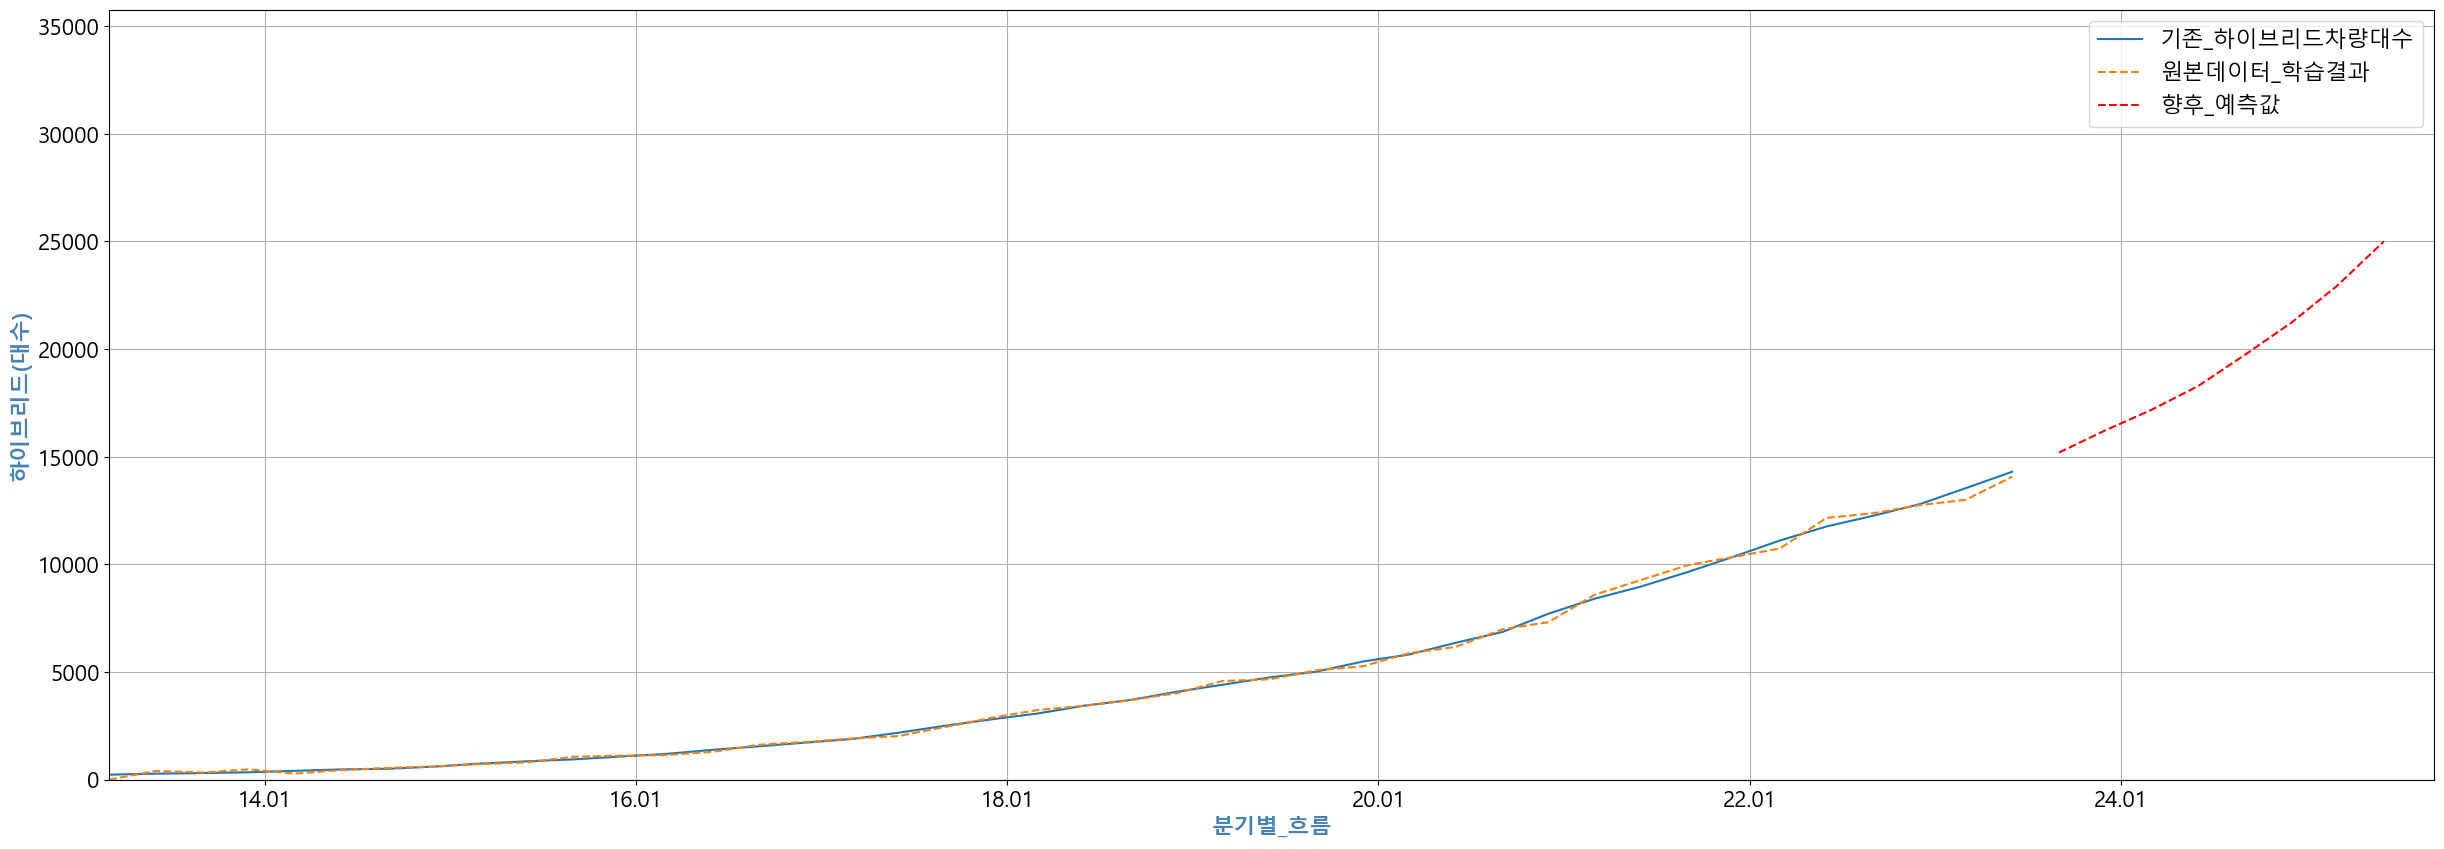

In [22]:
plt.rcParams["font.size"] = 16

plt.figure(figsize=(30,10))

# 원본 데이터
sb.lineplot(data=df2, x=df2.index, y='하이브리드(대수)', label='기존_하이브리드차량대수')

# 원본에 대한 학습결과
sb.lineplot(x=fv2.index, y=fv2.values, label='원본데이터_학습결과', linestyle='--')

# 향후 2년간의 예측값
sb.lineplot(x=fc2.index, y=fc2.values, label='향후_예측값', linestyle='--', color='red')

plt.xlabel('분기별_흐름',color='steelblue',fontweight='bold')
plt.ylabel('하이브리드(대수)',color='steelblue',fontweight='bold')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*2.5])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

> 하이브리드 차량의 경우 향후 2년간 지속적인 상승세가 예측되며 25년 3분기 기준(현재시점 기준 2년 후) 25000대에 근접할 것으로 예상된다.

### 수소(대수) 시계열 분석

In [23]:
model_name = 'additive'         # 가법 모델
# model_name = 'multiplicative'   # 승법 모델

sd3 = seasonal_decompose(df2['수소(대수)'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df3 = DataFrame({
    '관측값': sd3.observed,
    '트렌드': sd3.trend,
    '계절성': sd3.seasonal,
    '잔차': sd3.resid
}, index=df2.index)

sd_df3.head()

,관측값,트렌드,계절성,잔차
년도,,,,
2013-03-01,0.0,NaN,-4.347917,NaN
2013-06-01,0.0,NaN,4.360417,NaN
2013-09-01,0.0,0.0,2.218750,-2.218750
2013-12-01,0.0,0.0,-2.231250,2.231250
2014-03-01,0.0,0.0,-4.347917,4.347917


결측치 수: 0


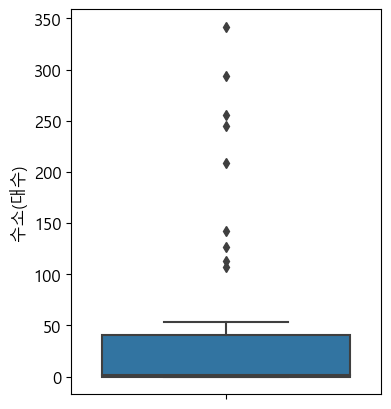

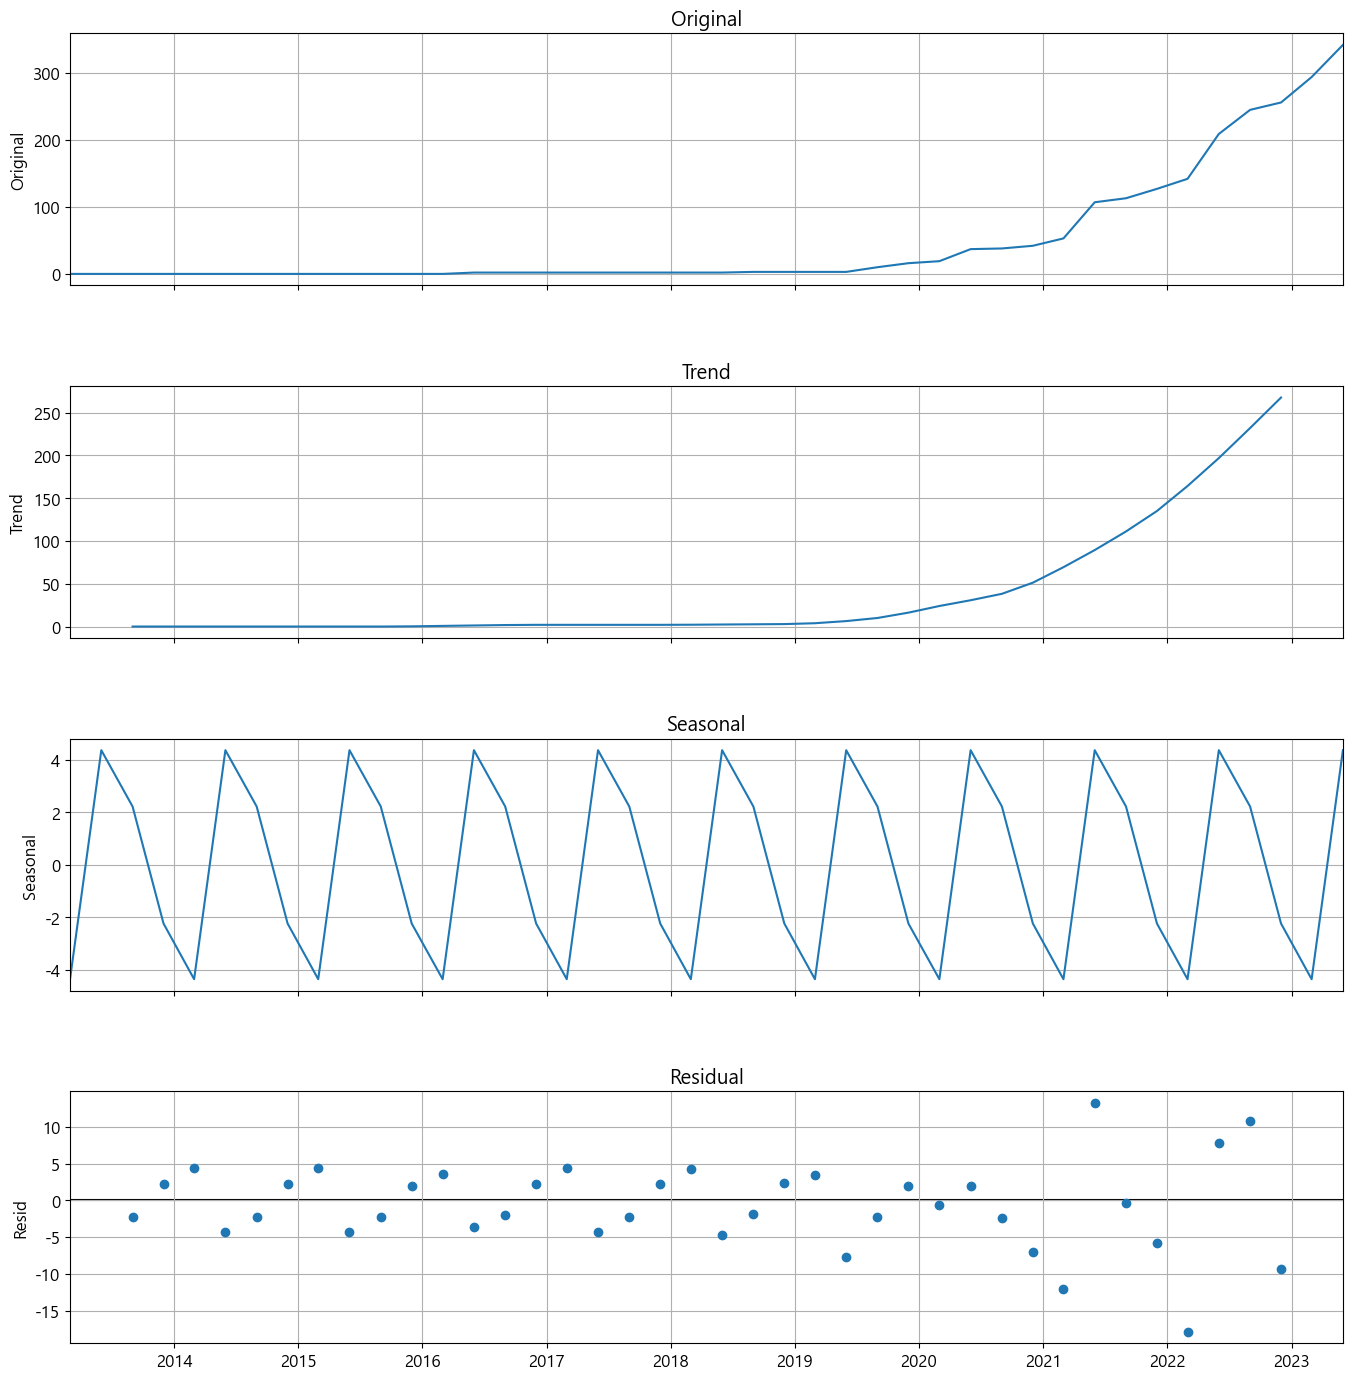

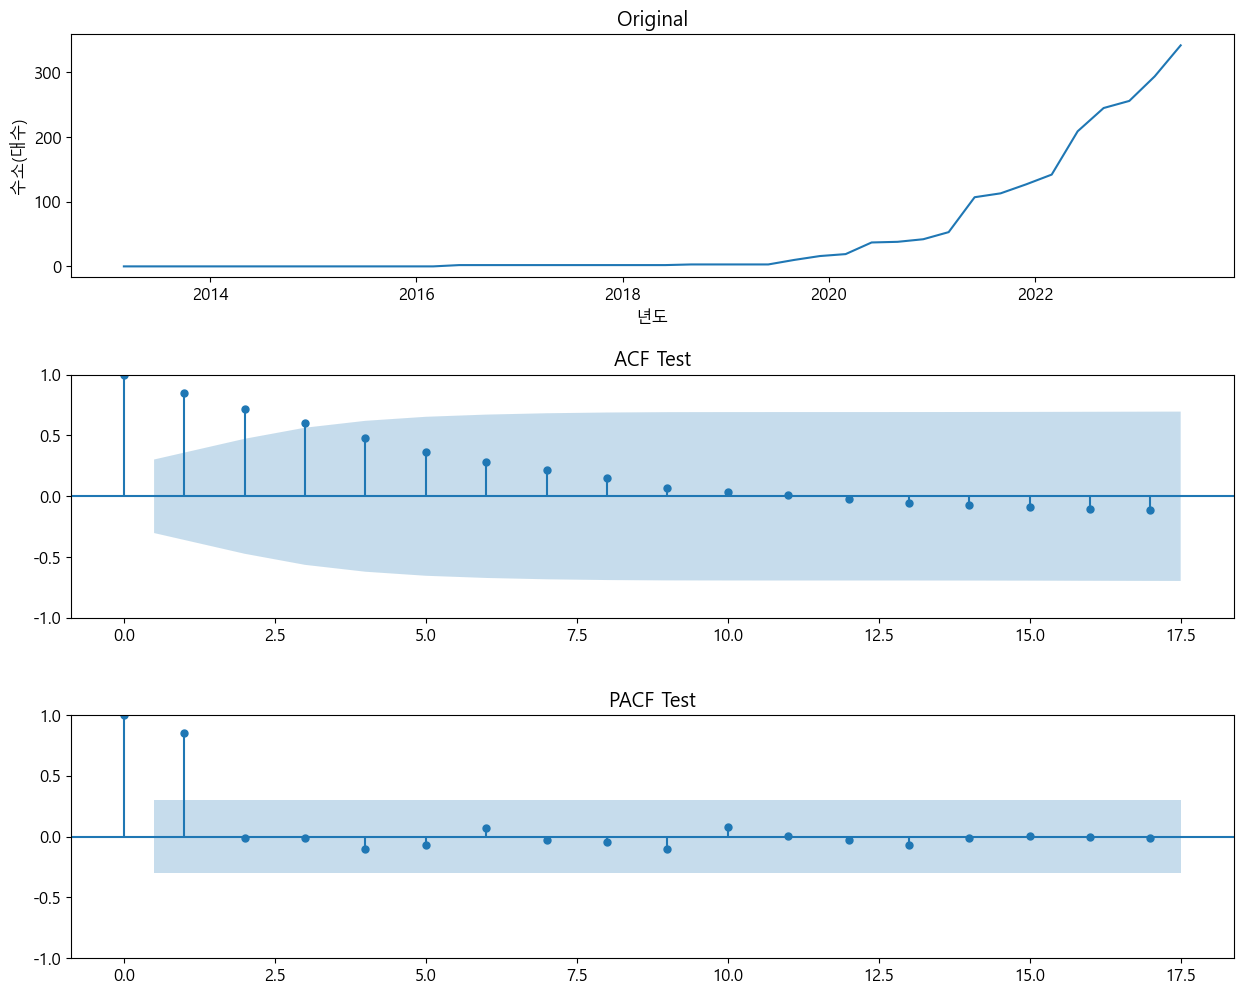

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.08058 |
| 유의수준(p-value)                  | 0.722753 |
| 최적차수(num of lags)              |       10 |
| 관측치 개수(num of observations)   |       31 |
| 기각값(Critical Values) 1%         | -3.66143 |
| 기각값(Critical Values) 5%         | -2.96053 |
| 기각값(Critical Values) 10%        | -2.61932 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.73218 |
| 유의수준(p-value)                  | 0.414613 |
| 최적차수(num of lags)              |        9 |
| 관측치 개수(num of observations)   |       31 |
| 기각값(Critical Values) 1%         | -3

In [24]:
exp_time_data(data=df2,yname="수소(대수)",sd_model='a',max_diff=5)

In [25]:
#auto arima 모델 이용하여 시계열 분석 진행

my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 3    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 3    # 계절성 주기 (분석가가 판단) #1년에 4분기(12/4)로 진행해서 수치는 3으로,(데이터 자체도 3개월주기)

model = auto_arima(
    y=df2['수소(대수)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,3,0)[3]             : AIC=374.640, Time=0.02 sec
 ARIMA(1,3,0)(1,3,0)[3]             : AIC=328.138, Time=0.10 sec
 ARIMA(1,3,0)(0,3,0)[3]             : AIC=335.303, Time=0.03 sec
 ARIMA(0,3,0)(1,3,0)[3]             : AIC=339.802, Time=0.05 sec
 ARIMA(1,3,0)(1,3,0)[3] intercept   : AIC=330.126, Time=0.11 sec

Best model:  ARIMA(1,3,0)(1,3,0)[3]          
Total fit time: 0.298 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   42
Model:             SARIMAX(1, 3, 0)x(1, 3, 0, 3)   Log Likelihood                -161.069
Date:                           Mon, 18 Sep 2023   AIC                            328.138
Time:                                   01:36:27   BIC                            332.341
Sample:                               03-01-2013   HQIC                           329.482
               

In [26]:
fv3 = model.fittedvalues()
fv3.head()

fc3 = model.predict(n_periods=8)
fc3.head()

2023-09-01    322.480375
2023-12-01    417.176670
2024-03-01    519.256671
2024-06-01    531.465234
2024-09-01    737.734964
Freq: QS-DEC, dtype: float64

In [27]:
last1 = df2.index.min()
last = df2.index.max()
xmin = last1
xmax = last+timedelta(days=730+100)
ymax = df2['수소(대수)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2013-03-01 00:00:00'), Timestamp('2025-09-08 00:00:00'), 342)

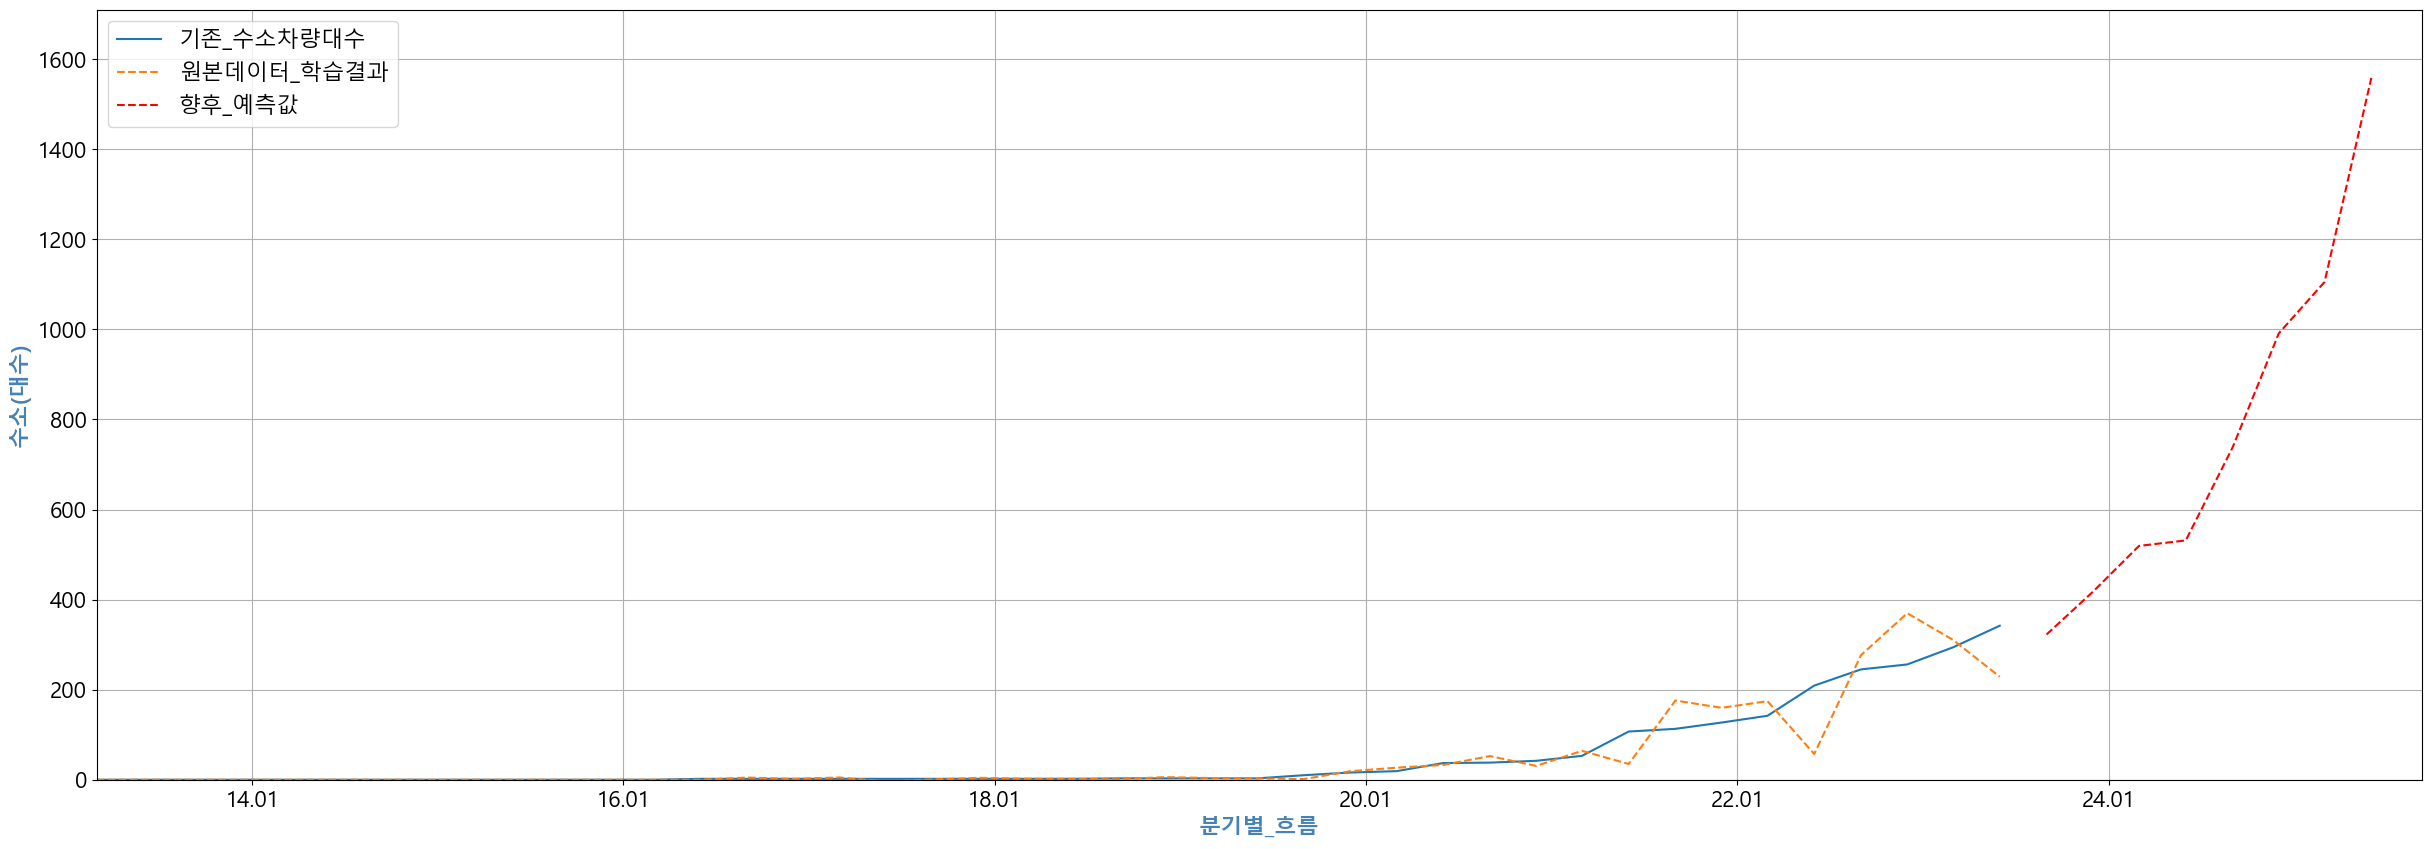

In [28]:
plt.rcParams["font.size"] = 16

plt.figure(figsize=(30,10))

# 원본 데이터
sb.lineplot(data=df2, x=df2.index, y='수소(대수)', label='기존_수소차량대수')

# 원본에 대한 학습결과
sb.lineplot(x=fv3.index, y=fv3.values, label='원본데이터_학습결과', linestyle='--')

# 향후 2년간의 예측값
sb.lineplot(x=fc3.index, y=fc3.values, label='향후_예측값', linestyle='--', color='red')

plt.xlabel('분기별_흐름',color='steelblue',fontweight='bold')
plt.ylabel('수소(대수)',color='steelblue',fontweight='bold')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*5])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

수소차의 경우 중간 중간 전년대비 수소차 증가율이 크게 오른 구간이 있어 기존 데이터와 학습데이터의 차이가 조금 있는것으로 추정된다. 또한 향후 2년간 지속적인 상승세가 예측되며 25년 3분기 기준(현재시점 기준 2년 후) 1600대에 근접할 것으로 예상된다.

### 친환경차 총합 시계열분석

In [29]:
# model_name = 'additive'         # 가법 모델
model_name = 'multiplicative'   # 승법 모델

sd4 = seasonal_decompose(df2['친환경차총합(대수)'], model=model_name)

# trend, seasonal, residual 데이터 프레임으로 변환
sd_df4 = DataFrame({
    '관측값': sd4.observed,
    '트렌드': sd4.trend,
    '계절성': sd4.seasonal,
    '잔차': sd4.resid
}, index=df2.index)

sd_df4.head()

,관측값,트렌드,계절성,잔차
년도,,,,
2013-03-01,235.0,NaN,1.001108,NaN
2013-06-01,282.0,NaN,1.010617,NaN
2013-09-01,310.0,317.000,0.993281,0.984533
2013-12-01,350.0,364.875,0.994994,0.964059
2014-03-01,417.0,415.250,1.001108,1.003103


결측치 수: 0


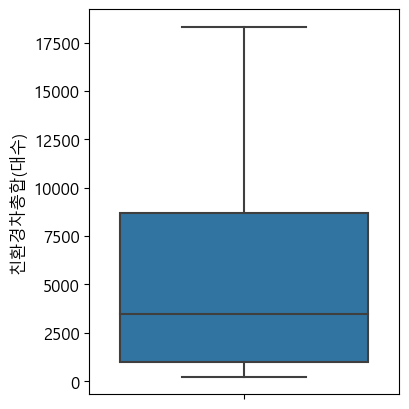

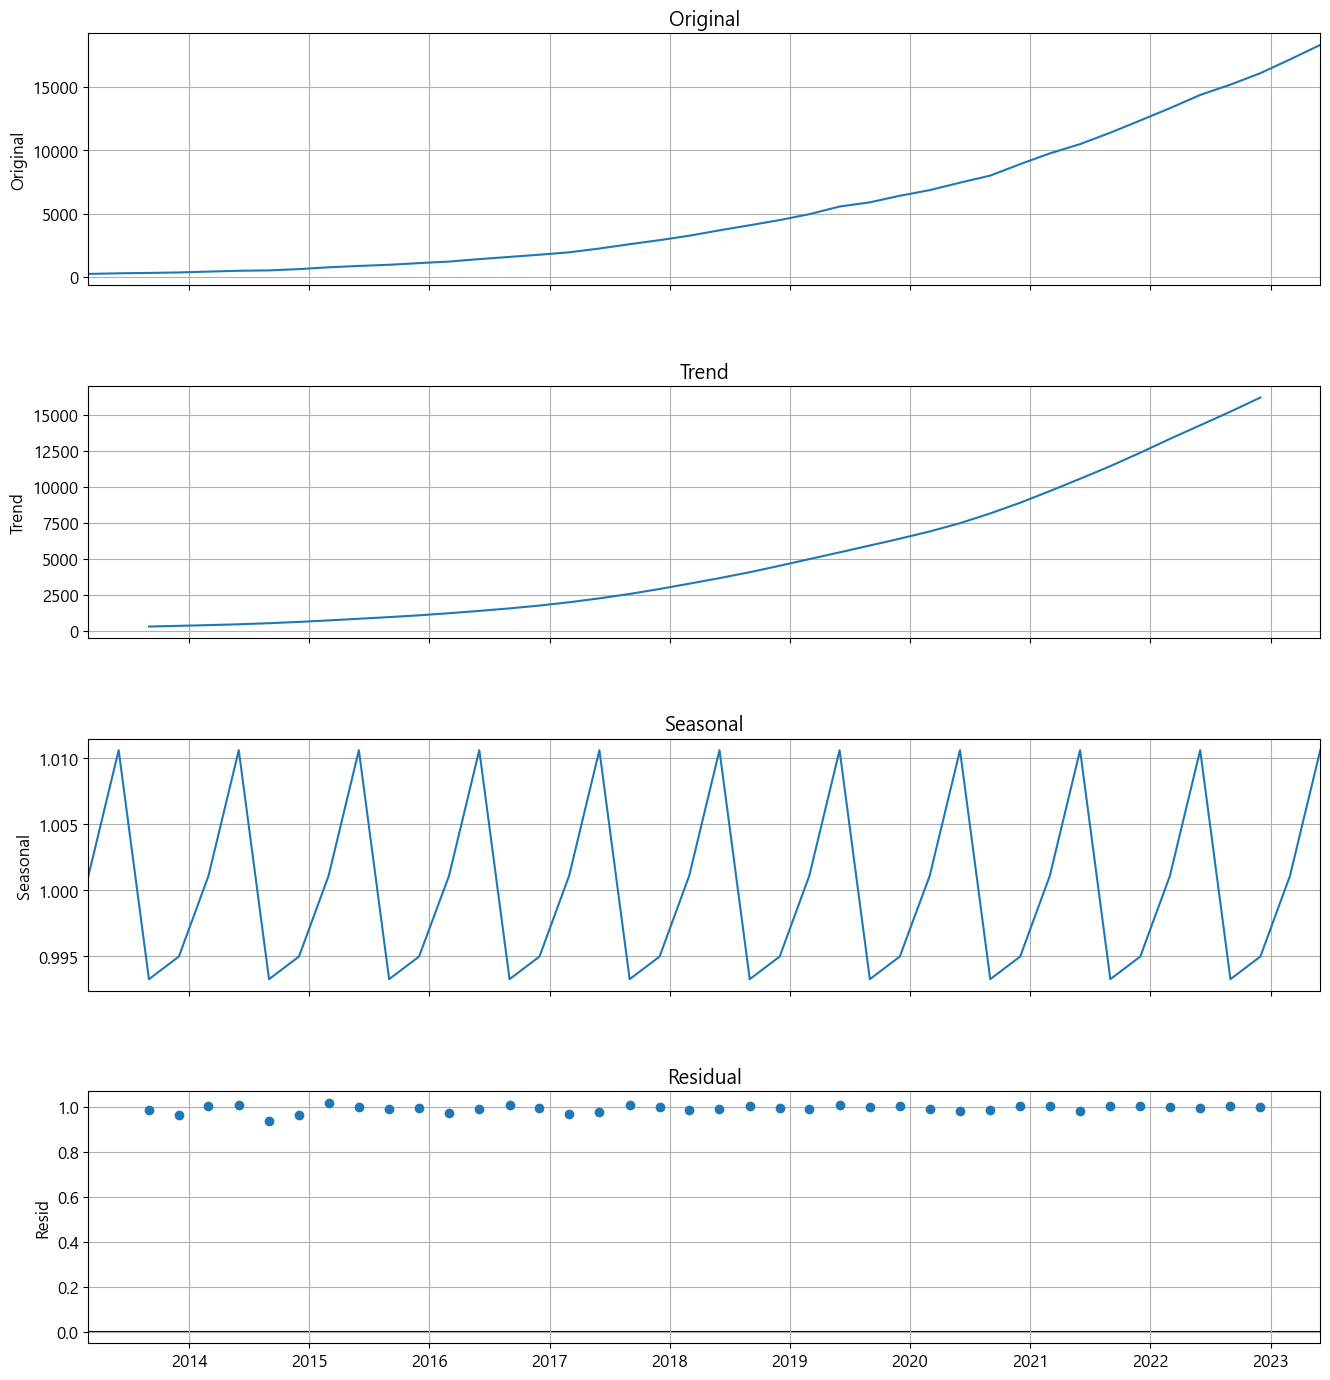

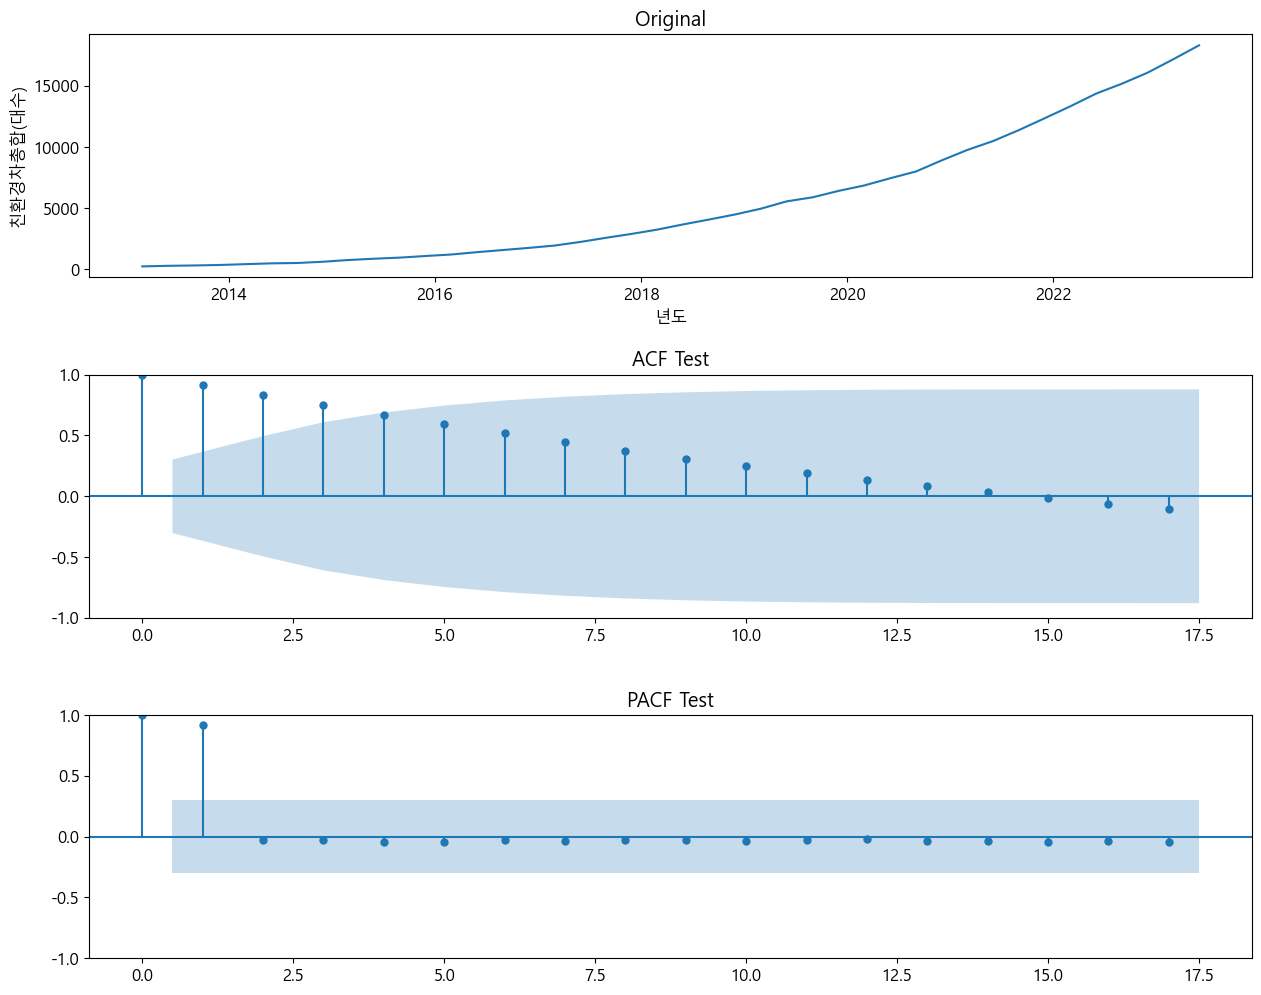

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          |  3.63336 |
| 유의수준(p-value)                  |        1 |
| 최적차수(num of lags)              |        1 |
| 관측치 개수(num of observations)   |       40 |
| 기각값(Critical Values) 1%         | -3.60556 |
| 기각값(Critical Values) 5%         | -2.93707 |
| 기각값(Critical Values) 10%        | -2.60699 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          |  0.96497 |
| 유의수준(p-value)                  | 0.993882 |
| 최적차수(num of lags)              |        3 |
| 관측치 개수(num of observations)   |       37 |
| 기각값(Critical Values) 1%         | -3

In [30]:
exp_time_data(data=df2,yname="친환경차총합(대수)",sd_model='m',max_diff=5)

In [31]:
#auto arima 모델 이용하여 시계열 분석 진행

my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 2    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 3    # 계절성 주기 (분석가가 판단) #1년에 4분기(12/4)로 진행해서 수치는 3으로,(데이터 자체도 3개월주기)

model = auto_arima(
    y=df2['친환경차총합(대수)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[3]             : AIC=484.961, Time=0.02 sec
 ARIMA(1,2,0)(1,2,0)[3]             : AIC=453.417, Time=0.03 sec
 ARIMA(1,2,0)(0,2,0)[3]             : AIC=474.883, Time=0.02 sec
 ARIMA(0,2,0)(1,2,0)[3]             : AIC=456.673, Time=0.03 sec
 ARIMA(1,2,0)(1,2,0)[3] intercept   : AIC=455.320, Time=0.06 sec

Best model:  ARIMA(1,2,0)(1,2,0)[3]          
Total fit time: 0.161 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   42
Model:             SARIMAX(1, 2, 0)x(1, 2, 0, 3)   Log Likelihood                -223.709
Date:                           Mon, 18 Sep 2023   AIC                            453.417
Time:                                   01:36:28   BIC                            457.996
Sample:                               03-01-2013   HQIC                           454.979
               

In [32]:
fv4 = model.fittedvalues()
fv4.head()

fc4 = model.predict(n_periods=8)
fc4.head()

2023-09-01    19561.376237
2023-12-01    20977.647637
2024-03-01    22279.153777
2024-06-01    23745.662397
2024-09-01    25465.683977
Freq: QS-DEC, dtype: float64

In [33]:
last1 = df2.index.min()
last = df2.index.max()
xmin = last1
xmax = last+timedelta(days=730+100)
ymax = df2['친환경차총합(대수)'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2013-03-01 00:00:00'), Timestamp('2025-09-08 00:00:00'), 18321)

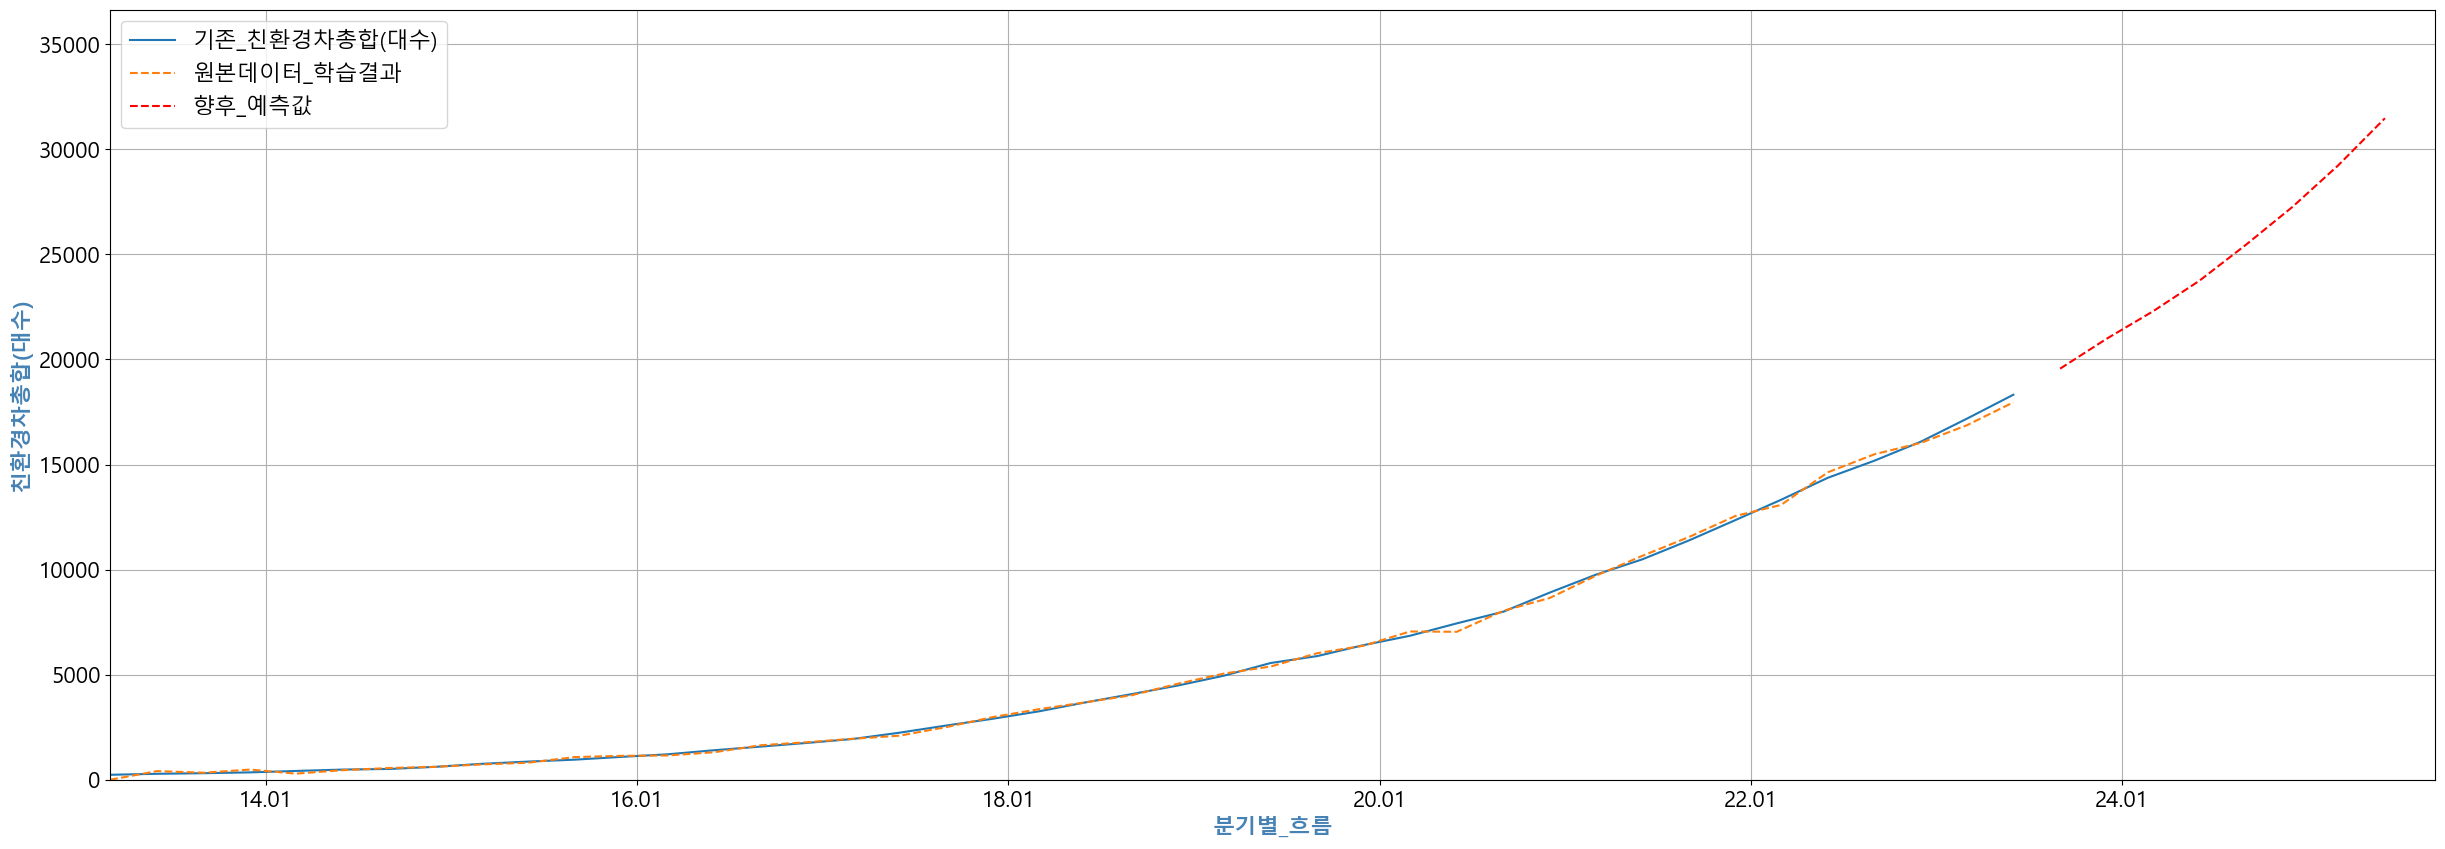

In [34]:
plt.rcParams["font.size"] = 16

plt.figure(figsize=(30,10))

# 원본 데이터
sb.lineplot(data=df2, x=df2.index, y='친환경차총합(대수)', label='기존_친환경차총합(대수)')

# 원본에 대한 학습결과
sb.lineplot(x=fv4.index, y=fv4.values, label='원본데이터_학습결과', linestyle='--')

# 향후 2년간의 예측값
sb.lineplot(x=fc4.index, y=fc4.values, label='향후_예측값', linestyle='--', color='red')

plt.xlabel('분기별_흐름',color='steelblue',fontweight='bold')
plt.ylabel('친환경차총합(대수)',color='steelblue',fontweight='bold')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

친환경차 총합대수를 그래프로 볼 때, 지속적으로 친환경차가 증가하고 있다는 것을 알 수 있으며, 향후 2년간 지속적인 상승세가 예측되고 25년 3분기 기준(현재시점 기준 2년 후) 30000대를 넘을 것으로 예상된다.

### 4개의 시계열 그래프를 한번에 묶어서 서브플롯으로 확인하기

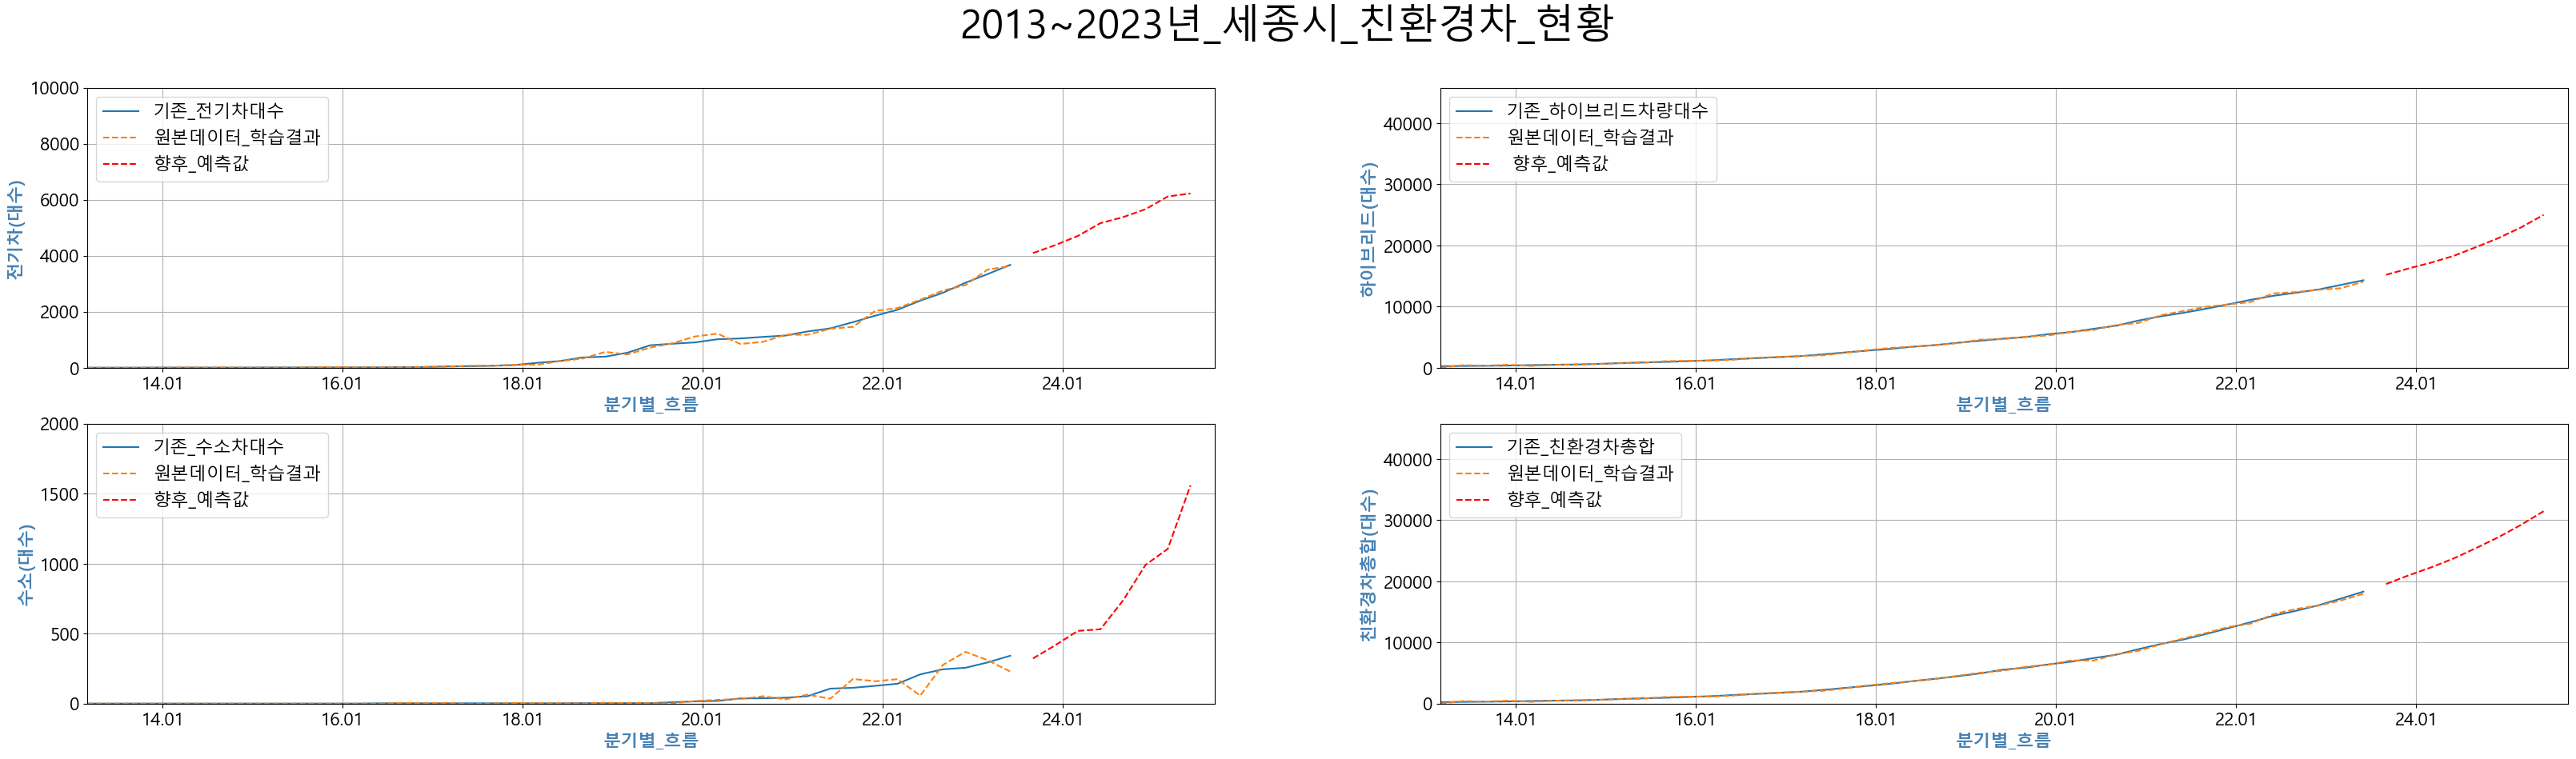

In [35]:
# 그래프 크기 및 폰트 설정
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 10)) #2행 2열 그래프 설정

fig.suptitle('2013~2023년_세종시_친환경차_현황',fontsize=36,color='#000000')

# 첫 번째 서브플롯: 전기차(대수)
ax1 = axes[0][0]
sb.lineplot(data=df2, x=df2.index, y='전기차(대수)', label='기존_전기차대수', ax=ax1)
sb.lineplot(x=fv.index, y=fv.values, label='원본데이터_학습결과', linestyle='--', ax=ax1)
sb.lineplot(x=fc.index, y=fc.values, label='향후_예측값', linestyle='--', color='red', ax=ax1)

# 첫 번째 서브플롯 옵션
ax1.set_xlabel('분기별_흐름', color='steelblue', fontweight='bold')
ax1.set_ylabel('전기차(대수)', color='steelblue', fontweight='bold')
ax1.legend(loc="upper left")
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([0, 10000])
monthyearFmt = mdates.DateFormatter('%y.%m')
ax1.xaxis.set_major_formatter(monthyearFmt)
ax1.grid()

# 두 번째 서브플롯: 하이브리드(대수)
ax2= axes[0][1]
sb.lineplot(data=df2, x=df2.index, y='하이브리드(대수)', label='기존_하이브리드차량대수', ax=ax2)
sb.lineplot(x=fv2.index, y=fv2.values,label ='원본데이터_학습결과', linestyle ='--' , ax=ax2 )
sb.lineplot(x=fc2.index,y=fc2.values,label =' 향후_예측값', linestyle ='--',color ='red', ax=ax2 )

# 두 번째 서브플롯 옵션
ax2.set_xlabel('분기별_흐름', color='steelblue', fontweight='bold')
ax2.set_ylabel('하이브리드(대수)', color='steelblue', fontweight='bold')
ax2.legend(loc="upper left")
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([0, ymax*2.5])
monthyearFmt = mdates.DateFormatter('%y.%m')
ax2.xaxis.set_major_formatter(monthyearFmt)
ax2.grid()

# 세 번째 서브플롯: 수소차(대수)
ax3 = axes[1][0]
sb.lineplot(data=df2, x=df2.index, y='수소(대수)', label='기존_수소차대수', ax=ax3)
sb.lineplot(x=fv3.index, y=fv3.values, label='원본데이터_학습결과', linestyle='--', ax=ax3)
sb.lineplot(x=fc3.index, y=fc3.values, label='향후_예측값', linestyle='--', color='red', ax=ax3)

# 세 번째 서브플롯 옵션
ax3.set_xlabel('분기별_흐름', color='steelblue', fontweight='bold')
ax3.set_ylabel('수소(대수)', color='steelblue', fontweight='bold')
ax3.legend(loc="upper left")
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([0, 2000])
monthyearFmt = mdates.DateFormatter('%y.%m')
ax3.xaxis.set_major_formatter(monthyearFmt)
ax3.grid()

# 네 번째 서브플롯: 친환경차 총합(대수)
ax4 = axes[1][1]
sb.lineplot(data=df2, x=df2.index, y='친환경차총합(대수)', label='기존_친환경차총합', ax=ax4)
sb.lineplot(x=fv4.index, y=fv4.values, label='원본데이터_학습결과', linestyle='--', ax=ax4)
sb.lineplot(x=fc4.index, y=fc4.values, label='향후_예측값', linestyle='--', color='red', ax=ax4)

# 세 번째 서브플롯 옵션
ax4.set_xlabel('분기별_흐름', color='steelblue', fontweight='bold')
ax4.set_ylabel('친환경차총합(대수)', color='steelblue', fontweight='bold')
ax4.legend(loc="upper left")
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([0, ymax*2.5])
monthyearFmt = mdates.DateFormatter('%y.%m')
ax4.xaxis.set_major_formatter(monthyearFmt)
ax4.grid()

plt.savefig('세종시_친환경차_현황및_예측그래프.png', dpi=300, format='png')

시계열 그래프로 확인 결과 전기차,하이브리드차,수소차 모두 시간이 지남에 따라 우상향을 띄우고 있다. 또한 향후  2년치 예측을 확인한 결과 25년 9월 기준 전기차는 6천대, 하이브리드차는 25000대 이상, 수소차는 1000대 이상으로 증가할 것으로 예측되었다.이를 통해 친환경차량의 수요가 지속적으로 증가하고있으며 늘어나는 친환경 차량에 대해 대비책, 즉 친환경차량 인프라 구축이 필요한 상황이다.

### 친환경차 별 증가율 barplot으로 확인

In [36]:
df.head()

,년도,전기차(대수),전기차_전년대비_증가율,하이브리드(대수),하이브리드_전년대비_증가율,수소(대수),수소차_전년대비_증가율,친환경차총합(대수),친환경차총합_전년대비_증가율,친환경차외(대수),세종시차량총합(대수),친환경차비율(%)
0,201303,0,0.0,235,0.00,0,0.0,235,0.00,49328,49563,0.5
1,201306,0,0.0,282,0.20,0,0.0,282,0.20,50394,50676,0.5
2,201309,0,0.0,310,0.10,0,0.0,310,0.10,51188,51498,0.6
3,201312,4,4.0,346,0.11,0,0.0,350,0.13,52539,52889,0.6
4,201403,4,0.0,413,0.19,0,0.0,417,0.19,54975,55392,0.7


In [37]:
df4=df.filter(['년도','전기차_전년대비_증가율','하이브리드_전년대비_증가율','수소차_전년대비_증가율','친환경차총합_전년대비_증가율'])
df4

df4['년도']=to_datetime(df4['년도'],format='%Y%m')
df4.dtypes

df4.set_index('년도',inplace=True)

# 수치 원복 (백분율)
df4 *= 100
df4.head()

,전기차_전년대비_증가율,하이브리드_전년대비_증가율,수소차_전년대비_증가율,친환경차총합_전년대비_증가율
년도,,,,
2013-03-01,0.0,0.0,0.0,0.0
2013-06-01,0.0,20.0,0.0,20.0
2013-09-01,0.0,10.0,0.0,10.0
2013-12-01,400.0,11.0,0.0,13.0
2014-03-01,0.0,19.0,0.0,19.0


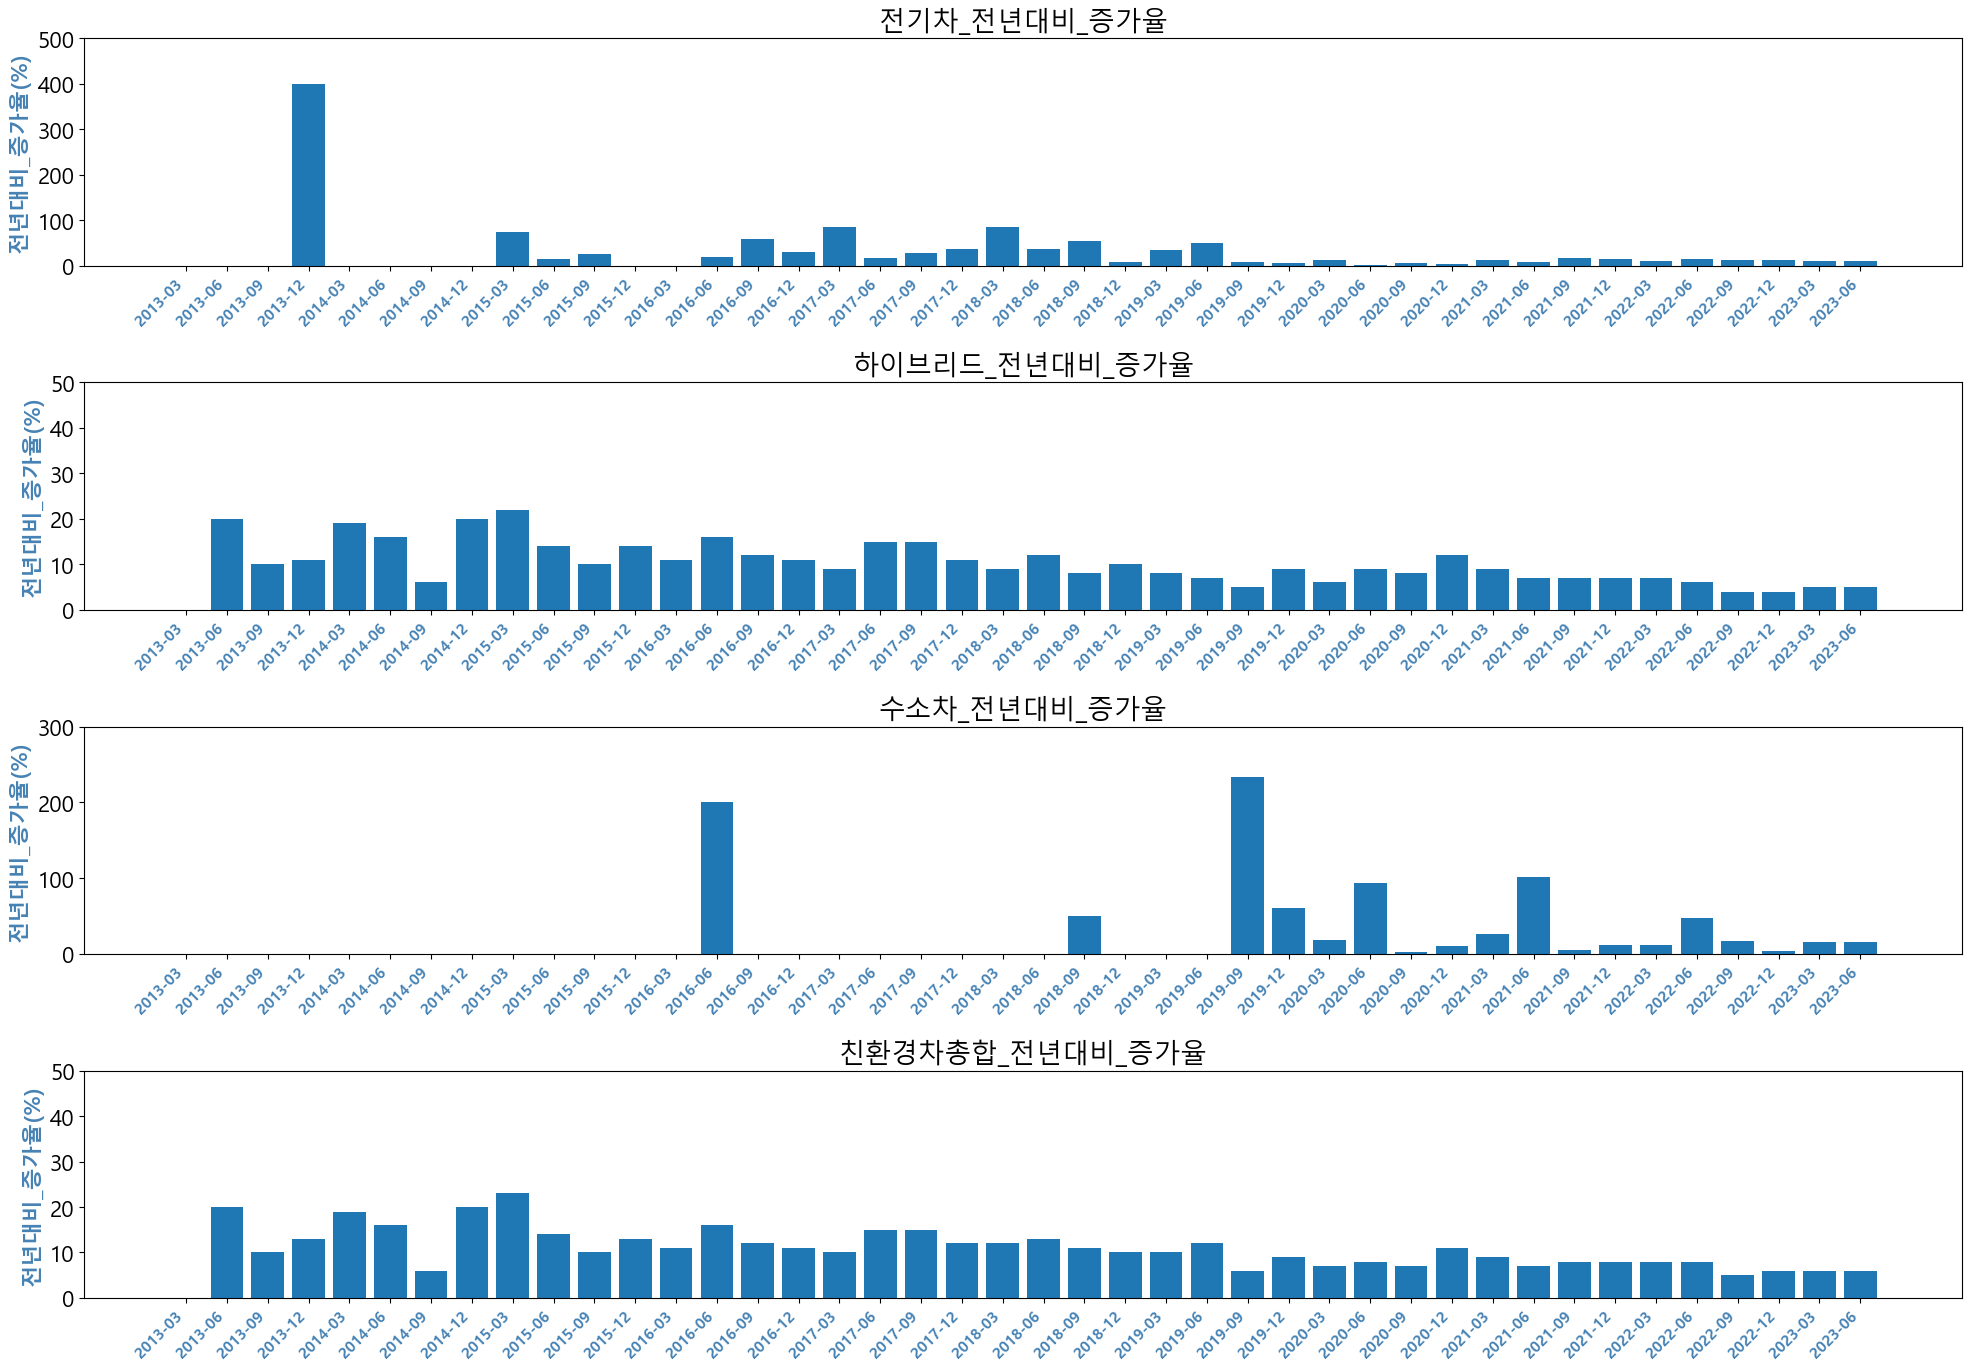

In [43]:
# 서브플롯 생성
fig, axes = plt.subplots(nrows=len(df4.columns), ncols=1, figsize=(20, 14))

# 인덱스를 datetime64 형식으로 변환
df4.index = to_datetime(df4.index)

# 각 데이터 컬럼별로 막대 그래프 생성
for i, col in enumerate(df4.columns):
    ax = axes[i]
    ax.bar(df4.index.strftime('%Y-%m'), df4[col])
    ax.set_ylabel('전년대비_증가율(%)', color='steelblue', fontweight='bold')
    ax.set_title(col)
    
    # x축 레이블 45도 회전 및 글자 폰트 크기 조정
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11, color='steelblue', fontweight='bold')

    # 각 서브플롯별로 ylim 값 설정
    if col == '전기차_전년대비_증가율':
        ax.set_ylim(0, 500)  # 전기차_전년대비_증가율에 대한 ylim 값 설정

    elif col =='수소차_전년대비_증가율':
        ax.set_ylim(0,300)

    else:
        ax.set_ylim(0, 50)  
    
# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()

시계열 그래프로 확인 결과 세종시내 친환경차 전년대비 증가율은 꾸준히 상승세인것으로 확인되었다.